In [226]:
import pickle, os
import numpy as np
import matplotlib.pyplot as plt

In [227]:
path = "C:/data/SiPM/waveforms/20240320/"
filename_list = ["LED_data_vb_27V_30kHz_1.4Vpp_2.3Vdc_duty0.25.pkl",
                 "LED_data_vb_27.5V_30kHz_1.4Vpp_2.3Vdc_duty0.25.pkl",
                 "LED_data_vb_28V_30kHz_1.4Vpp_2.3Vdc_duty0.25.pkl", 
                 "LED_data_vb_28.5V_30kHz_1.4Vpp_2.3Vdc_duty0.25.pkl",
                 "LED_data_vb_29V_30kHz_1.4Vpp_2.3Vdc_duty0.25.pkl"]
ov_list  = [27,27.5,28,28.5,29]

In [228]:
ovs_dict = {}
for j,filename in enumerate(filename_list):
    
    with open(os.path.join(path, filename), 'rb') as fin:
        data_dict = pickle.load(fin)

    nwaveforms = len( data_dict.keys() ) - 1
    print("Got %d waveforms"%nwaveforms + " for file "+filename)

    ovs_dict[ov_list[j]] = {'nwaveforms': nwaveforms, 'data_dict': data_dict}


Got 40000 waveforms for file LED_data_vb_27V_30kHz_1.4Vpp_2.3Vdc_duty0.25.pkl
Got 40000 waveforms for file LED_data_vb_27.5V_30kHz_1.4Vpp_2.3Vdc_duty0.25.pkl
Got 40000 waveforms for file LED_data_vb_28V_30kHz_1.4Vpp_2.3Vdc_duty0.25.pkl
Got 40000 waveforms for file LED_data_vb_28.5V_30kHz_1.4Vpp_2.3Vdc_duty0.25.pkl
Got 40000 waveforms for file LED_data_vb_29V_30kHz_1.4Vpp_2.3Vdc_duty0.25.pkl


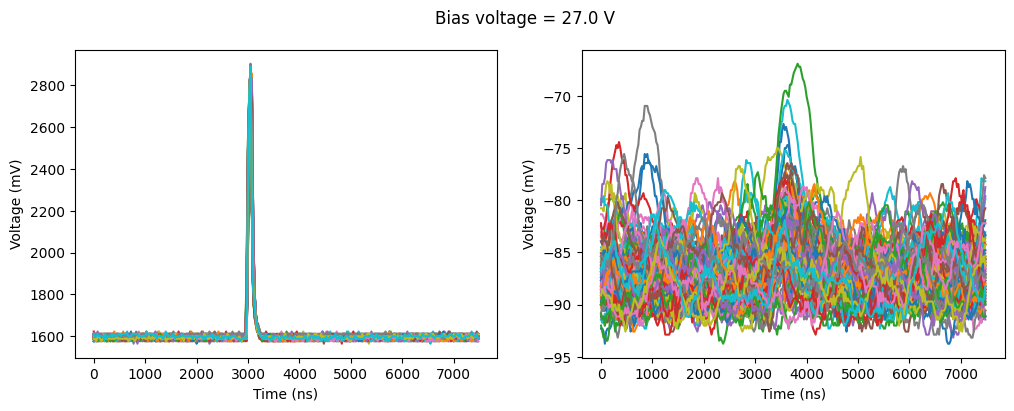

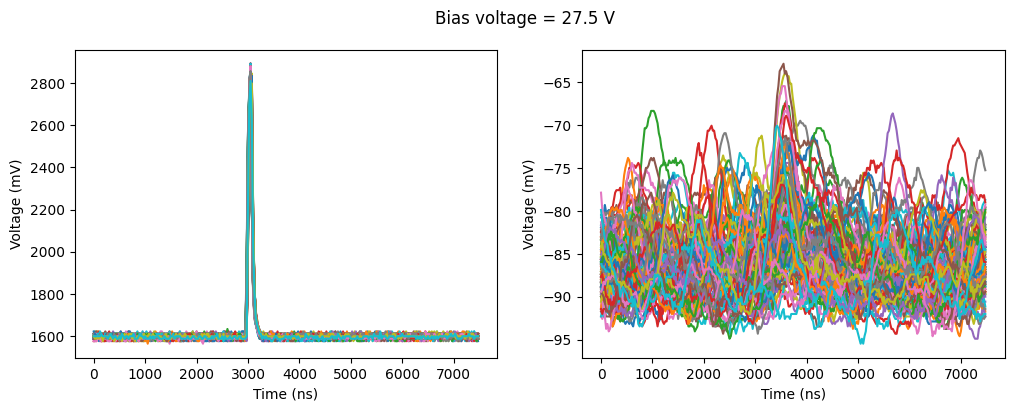

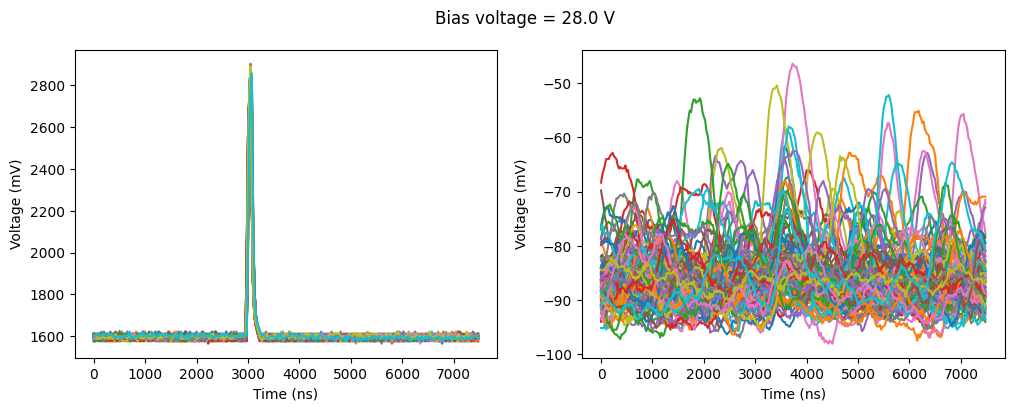

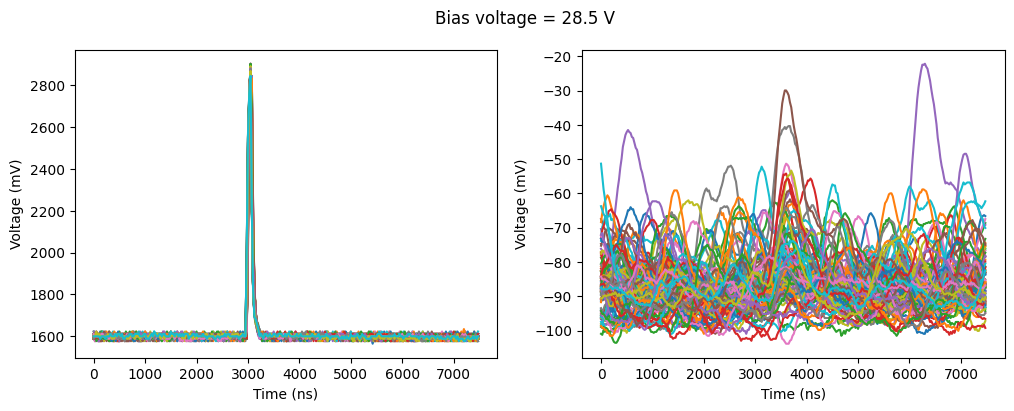

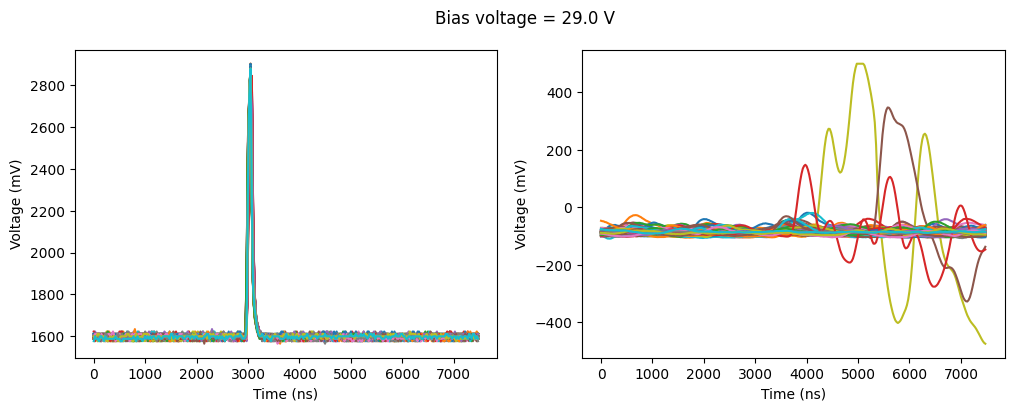

In [229]:
make_plot = True
max_figs = 100

for ov in ov_list:

    nwaveforms = ovs_dict[ov]['nwaveforms']
    data_dict = ovs_dict[ov]['data_dict']

    if(nwaveforms > max_figs):
        downsamp = int(nwaveforms/max_figs)
    else:
        downsamp = 1

    if(make_plot):

        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1)
        for j in range(nwaveforms):
            if(j%downsamp != 0): continue
            plt.plot(data_dict['time'], data_dict[j][0])
            plt.xlabel('Time (ns)')
            plt.ylabel('Voltage (mV)')

        plt.subplot(1,2,2)
        for j in range(nwaveforms):
            if(j%downsamp != 0): continue
            plt.plot(data_dict['time'], data_dict[j][1])
            plt.xlabel('Time (ns)')
            plt.ylabel('Voltage (mV)')

        plt.suptitle("Bias voltage = %.1f V"%ov)



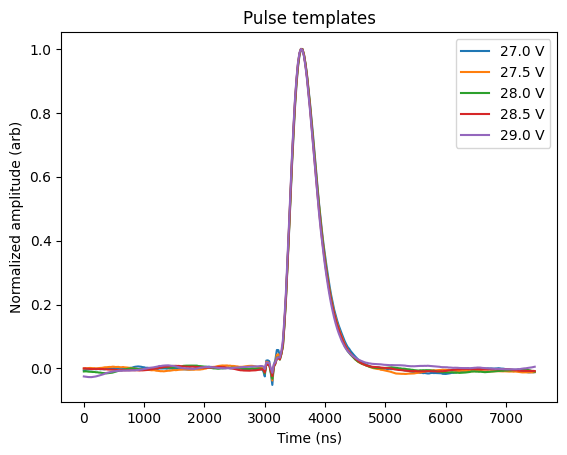

In [232]:
template_dict = {}

plt.figure()
for ov in ov_list:

    nwaveforms = ovs_dict[ov]['nwaveforms']
    data_dict = ovs_dict[ov]['data_dict']

    ## make average template
    template = np.zeros_like(data_dict['time'])

    nwfm = 0
    for j in range(nwaveforms):

        cdat = data_dict[j][1]

        ## throw out bad traces
        if np.max(cdat) > 0:
            continue

        template += cdat
        nwfm += 1

    template /= nwfm
    template -= np.median(template[:100])
    template /= np.max(template)

    plt.plot(data_dict['time'], template, label="%.1f V"%ov)
    plt.xlabel('Time (ns)')
    plt.ylabel('Normalized amplitude (arb)')

    template_dict[ov] = template

plt.title("Pulse templates")
plt.legend()
plt.show()

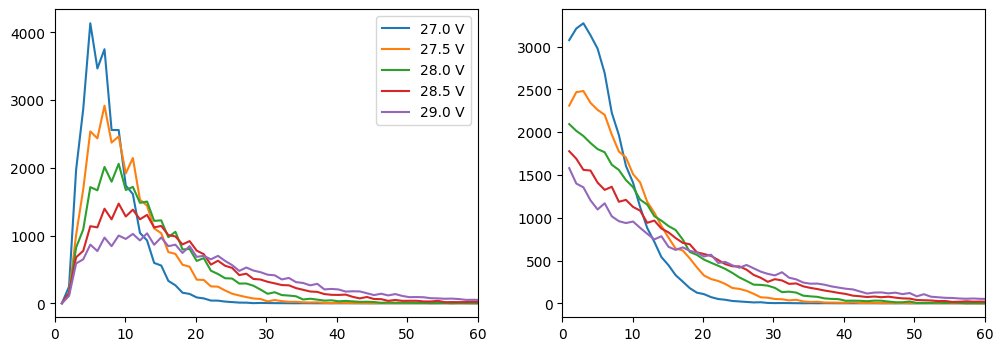

In [233]:
plt.figure(figsize=(12,4))

for ov in ov_list:

    nwaveforms = ovs_dict[ov]['nwaveforms']
    data_dict = ovs_dict[ov]['data_dict']

    recon_amps = []
    window  = [3000, 4000]

    mpts = (data_dict['time']>window[0]) & (data_dict['time']<window[1])


    for j in range(nwaveforms):

        cdat = data_dict[j][1]
        
        ## baseline subtract
        cdat -= np.median(cdat[:100])

        fit = np.sum( cdat*template ) / np.sum(template**2)

        midx = np.argmax(np.abs(cdat[mpts]))
        max_val = cdat[mpts][midx]
        recon_amps.append( [max_val, fit] )

    recon_amps = np.array(recon_amps)

    bins = np.linspace(0,150,150)
    bc = bins[:-1] + np.diff(bins)

    h_max, be = np.histogram( recon_amps[:,0], bins=bins )
    h_fit, be = np.histogram( recon_amps[:,1], bins=bins )


    plt.subplot(1,2,1)
    plt.plot(bc, h_max, label="%.1f V"%ov)
    plt.xlim(0,60)
    plt.subplot(1,2,2)
    plt.plot(bc, h_fit)
    plt.xlim(0,60)

plt.subplot(1,2,1)
plt.legend()
plt.show()